# Evaluating the Human Study

## Settings

In [1]:
!pip install -q --upgrade google-api-python-client google-auth-httplib2 google-auth-oauthlib torchmetrics

In [2]:
import json
from pathlib import Path

import pandas as pd
import seaborn as sns
import torch
from google.oauth2 import service_account
from googleapiclient.discovery import build
from matplotlib import pyplot as plt
from torchmetrics import Accuracy, F1Score, MetricCollection, Precision, Recall
from tqdm import tqdm


/usr/local/lib/python3.10/dist-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: '/usr/local/lib/python3.10/dist-packages/torchvision/image.so: undefined symbol: _ZN3c1017RegisterOperatorsD1Ev'If you don't plan on using image functionality from `torchvision.io`, you can ignore this warning. Otherwise, there might be something wrong with your environment. Did you have `libjpeg` or `libpng` installed before building `torchvision` from source?
  warn(
/usr/local/lib/python3.10/dist-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Study

**Note:** Replace `binary` in the definition of `mode` (frist line of the following cell) with `multi`/`open` to run this for the multi-choice or open-ended study.

In [50]:
mode = "multi"  # Change to "multi" or "open" for multi-choice or open-ended study
study_file = Path(f"../../generated-dataset-30_000/human-study/{mode}/study_forms_{mode}.csv")
ground_truth_file = study_file.with_name(study_file.name.replace("study_forms_", "study_data_"))
form_results = study_file.with_name(study_file.name.replace("study_forms_", "form_responses_"))
final_results = study_file.with_name(study_file.name.replace("study_forms_", "final_results_"))
form_results

PosixPath('../../generated-dataset-30_000/human-study/multi/form_responses_multi.csv')

In [51]:
study_setup = pd.read_csv(study_file)
study_setup["study_entry_ids"] = study_setup["study_entry_ids"].apply(json.loads)
study_setup = study_setup.explode("study_entry_ids").set_index("study_entry_ids")
study_setup

,block,form_id,responder_uri
study_entry_ids,,,
0,0,1StDzIa1qPyJLsAqQKa-2PAhvEc2p3qwFvln8-vphWcA,https://docs.google.com/forms/d/e/1FAIpQLSfiyc...
1,0,1StDzIa1qPyJLsAqQKa-2PAhvEc2p3qwFvln8-vphWcA,https://docs.google.com/forms/d/e/1FAIpQLSfiyc...
2,0,1StDzIa1qPyJLsAqQKa-2PAhvEc2p3qwFvln8-vphWcA,https://docs.google.com/forms/d/e/1FAIpQLSfiyc...
3,0,1StDzIa1qPyJLsAqQKa-2PAhvEc2p3qwFvln8-vphWcA,https://docs.google.com/forms/d/e/1FAIpQLSfiyc...
4,0,1StDzIa1qPyJLsAqQKa-2PAhvEc2p3qwFvln8-vphWcA,https://docs.google.com/forms/d/e/1FAIpQLSfiyc...
...,...,...,...
815,40,144u0e0fRjezAdKq6Ot294IMyHrO3RvjA0NDbHGfKwZ4,https://docs.google.com/forms/d/e/1FAIpQLScsdT...
816,40,144u0e0fRjezAdKq6Ot294IMyHrO3RvjA0NDbHGfKwZ4,https://docs.google.com/forms/d/e/1FAIpQLScsdT...
817,40,144u0e0fRjezAdKq6Ot294IMyHrO3RvjA0NDbHGfKwZ4,https://docs.google.com/forms/d/e/1FAIpQLScsdT...


In [52]:
SERVICE_ACCOUNT_FILE = "../../research-430307-ad3438ad46d0.json"
SCOPES = [
    "https://www.googleapis.com/auth/forms.body.readonly",
    "https://www.googleapis.com/auth/forms.responses.readonly",
]

credentials = service_account.Credentials.from_service_account_file(SERVICE_ACCOUNT_FILE, scopes=SCOPES)

forms_service = build("forms", "v1", credentials=credentials)

### For binary and multi

In [ ]:
collected_results = {}

for form_id in tqdm(study_setup["form_id"].unique()):
    form = forms_service.forms().get(formId=form_id).execute()
    responses = forms_service.forms().responses().list(formId=form_id).execute()

    if not responses or not responses["responses"]:
        print(f"Form {form_id} has no responses")
        continue
    # elif responses:
    #     print(f"Form {form_id} has {len(responses['responses'])} responses")

    question_mapping = {}
    for item in form["items"]:
        if "title" in item and "Question #" in item["title"]:
            question_number = int(item["title"].split("#")[-1])
            # Find the next item which contains the questionItem
            next_index = form["items"].index(item) + 1
            if next_index < len(form["items"]):
                next_item = form["items"][next_index]
                if "questionItem" in next_item:
                    question_id = next_item["questionItem"]["question"]["questionId"]
                    question_mapping[question_id] = question_number
                if "questionItem" in next_item:
                    question_id = next_item["questionItem"]["question"]["questionId"]
                    question_mapping[question_id] = question_number

    results = [
        {
            "study_entry_ids": (
                -1 if "00999999" == elem["questionId"] else question_mapping[elem["questionId"]]
            ),
            "answer": elem["textAnswers"]["answers"][0]["value"],
        }
        for elem in responses["responses"][0]["answers"].values()
    ]
    study_entry_df = pd.DataFrame(results)

    prolific_id = study_entry_df[study_entry_df["study_entry_ids"] == -1]["answer"].item()
    study_entry_df = study_entry_df[study_entry_df["study_entry_ids"] != -1]
    study_entry_df["study_entry_ids"] -= 1  # Undo the offset for nice presentation
    study_entry_df.set_index("study_entry_ids", inplace=True)

    collected_results[prolific_id] = study_entry_df

all_results = pd.concat(
    collected_results.values(), keys=collected_results.keys(), names=["prolific_id"]
).reset_index(level=0)
all_results.to_csv(form_results)

### For open

In [7]:
collected_results = {}
collected_results_identification = {}

for form_id in tqdm(study_setup["form_id"].unique()):
    form = forms_service.forms().get(formId=form_id).execute()
    responses = forms_service.forms().responses().list(formId=form_id).execute()

    if not responses or not responses["responses"]:
        print(f"Form {form_id} has no responses")
        continue
    # elif responses:
    #     print(f"Form {form_id} has {len(responses['responses'])} responses")

    questionid_to_answer = {}
    questionid_to_indentification_answer = {}
    for item in form["items"]:
        if "title" in item and "Question #" in item["title"]:
            question_number = int(item["title"].split("#")[-1])
            # Find the next item which contains the questionItem
            index = form["items"].index(item)
            if index + 2 < len(form["items"]):
                item_identify = form["items"][index + 1]
                item_answer = form["items"][index + 2]
                if "questionGroupItem" in item_identify:
                    for action_index, item in enumerate(item_identify["questionGroupItem"]["questions"]):
                        question_id = item["questionId"]
                        questionid_to_indentification_answer[question_id] = (question_number, action_index)
                if "questionItem" in item_answer:
                    question_id = item_answer["questionItem"]["question"]["questionId"]
                    questionid_to_answer[question_id] = question_number

    results = []
    results_identification = []
    for elem in responses["responses"][0]["answers"].values():
        q_id = elem["questionId"]
        value = elem["textAnswers"]["answers"][0]["value"]
        if q_id == "00999999":
            prolific_id = value
        elif q_id in questionid_to_answer:
            results.append(
                {
                    "study_entry_ids": questionid_to_answer[elem["questionId"]],
                    "answer": value,
                }
            )
        elif q_id in questionid_to_indentification_answer:
            question_number, action_index = questionid_to_indentification_answer[q_id]
            results_identification.append(
                {
                    "study_entry_ids": question_number,
                    "action_index": action_index,
                    "answer": value,
                }
            )
        else:
            raise ValueError(f"Question ID {q_id} not found in the mapping")

    study_entry_df = pd.DataFrame(results)
    study_entry_df["study_entry_ids"] -= 1  # Undo the offset for nice presentation
    study_entry_df.set_index("study_entry_ids", inplace=True)
    collected_results[prolific_id] = study_entry_df

    id_study_entry_df = pd.DataFrame(results_identification)
    id_study_entry_df["study_entry_ids"] -= 1  # Undo the offset for nice presentation
    id_study_entry_df.set_index("study_entry_ids", inplace=True)
    collected_results_identification[prolific_id] = id_study_entry_df

all_results = pd.concat(
    collected_results.values(), keys=collected_results.keys(), names=["prolific_id"]
).reset_index(level=0)
all_results.sort_values(by=["study_entry_ids"], inplace=True)
all_results.to_csv(form_results)

all_results_identification = pd.concat(
    collected_results_identification.values(),
    keys=collected_results_identification.keys(),
    names=["prolific_id"],
).reset_index(level=0)
all_results_identification.sort_values(by=["study_entry_ids", "action_index"], inplace=True)
all_results_identification.to_csv(final_results)

 15%|█▍        | 6/41 [00:10<00:56,  1.60s/it]

Form 15NxGLvyOghcn0_sI7Y4hy0clWyuAXMceX2mKJEeFEoo has no responses


 24%|██▍       | 10/41 [00:16<00:46,  1.49s/it]

Form 1U-tXcdFK1CHdMy-n3JuO3_iI8kLw7_Lhk2hoFynhJ1g has no responses


 32%|███▏      | 13/41 [00:20<00:37,  1.32s/it]

Form 1zriSJOKufrz6uGxPzsBFykk3I9bYS49ybYNShgZ-lF8 has no responses


 63%|██████▎   | 26/41 [00:39<00:17,  1.14s/it]

Form 1sSgcysLS9NrCQV3k_PcPucSUF_tG38dzY4it-C6EOIs has no responses


 66%|██████▌   | 27/41 [00:39<00:14,  1.02s/it]

Form 1qRFfmb1r3JEK4Cx-o5YlwhU3iN6-1Ndg4JU1tCVqPAs has no responses


 68%|██████▊   | 28/41 [00:41<00:14,  1.08s/it]

Form 1n8T9TbyZlVUr3Dkay1M0y08V7HLdrTekh0yp_wY6mBw has no responses


 71%|███████   | 29/41 [00:41<00:11,  1.01it/s]

Form 1zgJdm7yICjutTgVfgakpxGQa8TTLbaDnzq0wcpoTJe4 has no responses


 73%|███████▎  | 30/41 [00:42<00:10,  1.02it/s]

Form 1W8f3HBAA0rvu7y4T1MuxOUNZWkYLW3nLfueVwlLaKb4 has no responses


 76%|███████▌  | 31/41 [00:44<00:11,  1.13s/it]

Form 1jMpFedblIm_64oiyGBvY9YBVBCH_6hmPcm0o9GJbul0 has no responses


 78%|███████▊  | 32/41 [00:45<00:10,  1.17s/it]

Form 1P16dxnoPyIf8kwqfYhAq8Ke8AlPEhCrsD6zCZT1Qsx8 has no responses


 80%|████████  | 33/41 [00:47<00:09,  1.23s/it]

Form 1HqUyT7zyuokHXJMnk5608pLHZMzfsrDvA3i_WNIxe8E has no responses


 83%|████████▎ | 34/41 [00:48<00:09,  1.35s/it]

Form 1oVq2XUuBQKpXqY1gtYPFSAPXv5YILfnQpR3ujfXMoYs has no responses


 85%|████████▌ | 35/41 [00:49<00:07,  1.20s/it]

Form 1qSUNUFve_RLWlw0wFUdKzHGRT7J5KyiRW0uQNP1aQGk has no responses


 88%|████████▊ | 36/41 [00:50<00:05,  1.09s/it]

Form 1leFe5XmKuzzEC7EbyPXNy4l8JopfNMcPxQ3YNetNDl0 has no responses


 90%|█████████ | 37/41 [00:52<00:05,  1.35s/it]

Form 1ih4MlzcOIpNFqHTZQpZnbM3oJOXeaXVrmOJL17uT-0Q has no responses


 93%|█████████▎| 38/41 [00:54<00:04,  1.48s/it]

Form 1DF8mm5U8rEfzkqeabySVmnEFSXX6xSrtDDIAH3w_nT0 has no responses


 95%|█████████▌| 39/41 [00:54<00:02,  1.26s/it]

Form 176afKBzY56B5GC6YPjCTZyWWFk3SZDB8HDNJl5C8Mro has no responses


 98%|█████████▊| 40/41 [00:55<00:01,  1.23s/it]

Form 16EAOYsRcZYfY-VDcuN5PND3OfN_pea-ycpiDUZD77Pc has no responses


100%|██████████| 41/41 [00:57<00:00,  1.40s/it]

Form 1uQTmcw2B9mQ40fAfM8CkBELo5lp6LeSExPFrhIWq_XM has no responses


In [53]:
all_results = pd.read_csv(form_results, index_col=0)

for pid, group in all_results.groupby("prolific_id"):
    print(pid + ":")
    for a in group["answer"]:
        print("    " + a)

all_results

59269aac7724de000109190f:
    B
    B
    A
    C
    C
    A
    A
    B
    B
    C
    B
    A
    B
    A
    A
    A
    A
    C
    A
    A
5b3fd4e03d066d0001608430:
    C
    C
    A
    C
    B
    A
    B
    A
    A
    B
    C
    A
    A
    C
    A
    B
    A
    A
    A
    A
5beb0d9d7569230001f88b7c:
    C
    C
    C
    A
    A
    C
    B
    A
    A
    C
    A
    B
    B
    B
    A
    B
    A
    C
    A
    C
5c6d938c79151c00017c7560:
    C
    B
    B
    B
    C
    C
    A
    C
    B
    C
    B
    A
    C
    C
    A
    B
    A
    B
    C
    A
5d29412ab711e9001ab74ece:
    B
    B
    A
    B
    B
    C
    A
    A
    A
    C
    B
    B
    B
    A
    C
    C
    A
    B
    B
    C
5efbce484cee781856fc95ef:
    C
    C
    B
    A
    C
    C
    A
    A
    C
    A
    C
    C
    A
    A
    B
    A
    C
    B
    A
    C
5f01b7e94738d231487f2911:
    A
    C
    C
    A
    C
    C
    C
    C
    B
    A
    A
    B
    B
    A
    B
    A
  

,prolific_id,answer
study_entry_ids,,
7,5c6d938c79151c00017c7560,C
18,5c6d938c79151c00017c7560,B
6,5c6d938c79151c00017c7560,B
17,5c6d938c79151c00017c7560,B
5,5c6d938c79151c00017c7560,C
...,...,...
800,612553565035b39b898d510d,B
811,612553565035b39b898d510d,B
809,612553565035b39b898d510d,C


In [69]:
all_results_open = pd.read_csv(final_results, index_col=0)
all_results_open

,block,form_id,responder_uri,prolific_id,participant_answer,sample_id,url,question,answer
study_entry_ids,,,,,,,,,
0,0,1StDzIa1qPyJLsAqQKa-2PAhvEc2p3qwFvln8-vphWcA,https://docs.google.com/forms/d/e/1FAIpQLSfiyc...,5c6d938c79151c00017c7560,A,27000,https://drive.google.com/uc?id=1p3r-97sKD2987-...,"What is the person doing at 4.354? A: waving, ...",A
1,0,1StDzIa1qPyJLsAqQKa-2PAhvEc2p3qwFvln8-vphWcA,https://docs.google.com/forms/d/e/1FAIpQLSfiyc...,5c6d938c79151c00017c7560,C,27001,https://drive.google.com/uc?id=1G8MSsUO3VwqCb1...,How often does the person engage in skipping r...,C
2,0,1StDzIa1qPyJLsAqQKa-2PAhvEc2p3qwFvln8-vphWcA,https://docs.google.com/forms/d/e/1FAIpQLSfiyc...,5c6d938c79151c00017c7560,B,27003,https://drive.google.com/uc?id=16eeEc7wbTx-zpy...,"Some time before a person was sitting down, wa...",B
3,0,1StDzIa1qPyJLsAqQKa-2PAhvEc2p3qwFvln8-vphWcA,https://docs.google.com/forms/d/e/1FAIpQLSfiyc...,5c6d938c79151c00017c7560,B,27004,https://drive.google.com/uc?id=1Cf796oRfXyD0XH...,"Throughout the duration from 5.579 to 10.231, ...",B
4,0,1StDzIa1qPyJLsAqQKa-2PAhvEc2p3qwFvln8-vphWcA,https://docs.google.com/forms/d/e/1FAIpQLSfiyc...,5c6d938c79151c00017c7560,A,27005,https://drive.google.com/uc?id=1Nzzlxnbu71uko4...,What did the person do immediately after wavin...,A
...,...,...,...,...,...,...,...,...,...
815,40,144u0e0fRjezAdKq6Ot294IMyHrO3RvjA0NDbHGfKwZ4,https://docs.google.com/forms/d/e/1FAIpQLScsdT...,612553565035b39b898d510d,B,27988,https://drive.google.com/uc?id=1OOKAZWw9B6qXsv...,What is the count of distinct activities that ...,B
816,40,144u0e0fRjezAdKq6Ot294IMyHrO3RvjA0NDbHGfKwZ4,https://docs.google.com/forms/d/e/1FAIpQLScsdT...,612553565035b39b898d510d,B,27989,https://drive.google.com/uc?id=1twLDtN0uoUWeST...,"Considering the options, what was the last act...",B
817,40,144u0e0fRjezAdKq6Ot294IMyHrO3RvjA0NDbHGfKwZ4,https://docs.google.com/forms/d/e/1FAIpQLScsdT...,612553565035b39b898d510d,B,27990,https://drive.google.com/uc?id=19-jQA0CaIaf_GK...,Which specific activity does the person execut...,B


In [70]:
participant_results = study_setup.join(all_results, how="inner").rename(
    columns={"answer": "participant_answer"}
)
participant_results

,block,form_id,responder_uri,prolific_id,participant_answer
study_entry_ids,,,,,
0,0,1StDzIa1qPyJLsAqQKa-2PAhvEc2p3qwFvln8-vphWcA,https://docs.google.com/forms/d/e/1FAIpQLSfiyc...,5c6d938c79151c00017c7560,A
1,0,1StDzIa1qPyJLsAqQKa-2PAhvEc2p3qwFvln8-vphWcA,https://docs.google.com/forms/d/e/1FAIpQLSfiyc...,5c6d938c79151c00017c7560,C
2,0,1StDzIa1qPyJLsAqQKa-2PAhvEc2p3qwFvln8-vphWcA,https://docs.google.com/forms/d/e/1FAIpQLSfiyc...,5c6d938c79151c00017c7560,B
3,0,1StDzIa1qPyJLsAqQKa-2PAhvEc2p3qwFvln8-vphWcA,https://docs.google.com/forms/d/e/1FAIpQLSfiyc...,5c6d938c79151c00017c7560,B
4,0,1StDzIa1qPyJLsAqQKa-2PAhvEc2p3qwFvln8-vphWcA,https://docs.google.com/forms/d/e/1FAIpQLSfiyc...,5c6d938c79151c00017c7560,A
...,...,...,...,...,...
815,40,144u0e0fRjezAdKq6Ot294IMyHrO3RvjA0NDbHGfKwZ4,https://docs.google.com/forms/d/e/1FAIpQLScsdT...,612553565035b39b898d510d,B
816,40,144u0e0fRjezAdKq6Ot294IMyHrO3RvjA0NDbHGfKwZ4,https://docs.google.com/forms/d/e/1FAIpQLScsdT...,612553565035b39b898d510d,B
817,40,144u0e0fRjezAdKq6Ot294IMyHrO3RvjA0NDbHGfKwZ4,https://docs.google.com/forms/d/e/1FAIpQLScsdT...,612553565035b39b898d510d,B


In [71]:
ground_truth = pd.read_csv(ground_truth_file, index_col=0)
ground_truth

,sample_id,url,question,answer
study_entry_id,,,,
0,27000,https://drive.google.com/uc?id=1p3r-97sKD2987-...,"What is the person doing at 4.354? A: waving, ...",A
1,27001,https://drive.google.com/uc?id=1G8MSsUO3VwqCb1...,How often does the person engage in skipping r...,C
2,27003,https://drive.google.com/uc?id=16eeEc7wbTx-zpy...,"Some time before a person was sitting down, wa...",B
3,27004,https://drive.google.com/uc?id=1Cf796oRfXyD0XH...,"Throughout the duration from 5.579 to 10.231, ...",B
4,27005,https://drive.google.com/uc?id=1Nzzlxnbu71uko4...,What did the person do immediately after wavin...,A
...,...,...,...,...
2451,29995,NaN,"Is the person performing A: throwing a ball, B...",B
2452,29996,NaN,"Among the provided choices, which action did t...",C
2453,29997,NaN,What activity took place directly after the pe...,C


In [75]:
df = participant_results.join(ground_truth, on="study_entry_ids", how="inner")
df

,block,form_id,responder_uri,prolific_id,participant_answer,sample_id,url,question,answer
study_entry_ids,,,,,,,,,
0,0,1StDzIa1qPyJLsAqQKa-2PAhvEc2p3qwFvln8-vphWcA,https://docs.google.com/forms/d/e/1FAIpQLSfiyc...,5c6d938c79151c00017c7560,A,27000,https://drive.google.com/uc?id=1p3r-97sKD2987-...,"What is the person doing at 4.354? A: waving, ...",A
1,0,1StDzIa1qPyJLsAqQKa-2PAhvEc2p3qwFvln8-vphWcA,https://docs.google.com/forms/d/e/1FAIpQLSfiyc...,5c6d938c79151c00017c7560,C,27001,https://drive.google.com/uc?id=1G8MSsUO3VwqCb1...,How often does the person engage in skipping r...,C
2,0,1StDzIa1qPyJLsAqQKa-2PAhvEc2p3qwFvln8-vphWcA,https://docs.google.com/forms/d/e/1FAIpQLSfiyc...,5c6d938c79151c00017c7560,B,27003,https://drive.google.com/uc?id=16eeEc7wbTx-zpy...,"Some time before a person was sitting down, wa...",B
3,0,1StDzIa1qPyJLsAqQKa-2PAhvEc2p3qwFvln8-vphWcA,https://docs.google.com/forms/d/e/1FAIpQLSfiyc...,5c6d938c79151c00017c7560,B,27004,https://drive.google.com/uc?id=1Cf796oRfXyD0XH...,"Throughout the duration from 5.579 to 10.231, ...",B
4,0,1StDzIa1qPyJLsAqQKa-2PAhvEc2p3qwFvln8-vphWcA,https://docs.google.com/forms/d/e/1FAIpQLSfiyc...,5c6d938c79151c00017c7560,A,27005,https://drive.google.com/uc?id=1Nzzlxnbu71uko4...,What did the person do immediately after wavin...,A
...,...,...,...,...,...,...,...,...,...
815,40,144u0e0fRjezAdKq6Ot294IMyHrO3RvjA0NDbHGfKwZ4,https://docs.google.com/forms/d/e/1FAIpQLScsdT...,612553565035b39b898d510d,B,27988,https://drive.google.com/uc?id=1OOKAZWw9B6qXsv...,What is the count of distinct activities that ...,B
816,40,144u0e0fRjezAdKq6Ot294IMyHrO3RvjA0NDbHGfKwZ4,https://docs.google.com/forms/d/e/1FAIpQLScsdT...,612553565035b39b898d510d,B,27989,https://drive.google.com/uc?id=1twLDtN0uoUWeST...,"Considering the options, what was the last act...",B
817,40,144u0e0fRjezAdKq6Ot294IMyHrO3RvjA0NDbHGfKwZ4,https://docs.google.com/forms/d/e/1FAIpQLScsdT...,612553565035b39b898d510d,B,27990,https://drive.google.com/uc?id=19-jQA0CaIaf_GK...,Which specific activity does the person execut...,B


In [58]:
df.to_csv(final_results)

In [59]:
df = pd.read_csv(final_results, index_col=0)

In [60]:
len(df["responder_uri"].value_counts())

41

In [61]:
df["responder_uri"].value_counts().sort_values()

responder_uri
https://docs.google.com/forms/d/e/1FAIpQLSfiycTdQ_SVxuTA8dQ7S4t7Hy9NsgcpGj7N5sSgTHUty3vO2Q/viewform    20
https://docs.google.com/forms/d/e/1FAIpQLSdNpO0td-mkdDuBlTXklYF4WWz0SdMfZuHld4DuF7WmEfDzcA/viewform    20
https://docs.google.com/forms/d/e/1FAIpQLSf2G__ilr4SKQNpuHkc7pevaod8x3Fyc9V9S-iOdfvihRMACg/viewform    20
https://docs.google.com/forms/d/e/1FAIpQLScW-jATrK2mpJWqJZe68tbYKPxp4KewiU-MARkzWEBR_zJ5kQ/viewform    20
https://docs.google.com/forms/d/e/1FAIpQLScURGIxictCyu0EVhkgYWlGZfGjR3C--ZcpZM-c-ED28-NL1Q/viewform    20
https://docs.google.com/forms/d/e/1FAIpQLSe87fW2Ct1TCOfJcr1FrUvJgS-qnS_fOrsrf7Yp1Ivwh7Nd5Q/viewform    20
https://docs.google.com/forms/d/e/1FAIpQLScBcz2xY3wsfiyIuqAcdwPzd1OWFEdYku_ZUkkJ3GT0odndtQ/viewform    20
https://docs.google.com/forms/d/e/1FAIpQLSeZsdm53CR9wpVktgcCDTIm-ZI81p7ccsxmbF72nJrzq-pNCg/viewform    20
https://docs.google.com/forms/d/e/1FAIpQLScAxsNlKvsRgxpKRjhikL0i08VF93AhCoxDBca_apL-ELz6xQ/viewform    20
https://docs.google.com/forms/d/

In [62]:
len(df["prolific_id"].value_counts())

41

In [63]:
df["prolific_id"].value_counts()

prolific_id
5c6d938c79151c00017c7560    20
6595812395737f2d67c13d22    20
60cb983ef93f96bbbc64972d    20
613a3d980fd9796d4b302d08    20
5f01b7e94738d231487f2911    20
666c74e87e4bb433eeb09972    20
66854d5ffa195c9f521c6a74    20
664f19dd49df83722ff540ec    20
66a24dba663bb9f262d2de21    20
5d29412ab711e9001ab74ece    20
62aa4c14bb1929c2d8ea602e    20
6571d1826543b8f44b2002bf    20
5efbce484cee781856fc95ef    20
66a68cfc424802b8c2bc1b28    20
6674b4a918f2509894b3294e    20
66a3782bfec493e02a2e88e8    20
66900002ff048b17b2161309    20
667006dfbf3938c8304c33d1    20
5beb0d9d7569230001f88b7c    20
6659dbba2a20aafdf3f1cc47    20
66a735fb0cc3558ad9b57855    20
66967015fc906dd90d20b926    20
60abafb26c818a0b6bb6b102    20
59269aac7724de000109190f    20
6153970bf6f5b4c470777d24    20
65a5badcf23c99cd089dfe91    20
5b3fd4e03d066d0001608430    20
616c5387784afe4b70a34de7    20
669a9c4018a6da2e08897a68    20
60fcd0cf324614c97cab543f    20
669ef258fe4e8c180f109f4c    20
66a68213ef65c89349d42113   

In [64]:
num_classes = len(df["answer"].value_counts())
task = "multiclass"
avg = "macro"

metrics = MetricCollection(
    {
        "accuracy": Accuracy(num_classes=num_classes, task=task, average=avg),
        "precision": Precision(num_classes=num_classes, task=task, average=avg),
        "recall": Recall(num_classes=num_classes, task=task, average=avg),
        "f1": F1Score(num_classes=num_classes, task=task, average=avg),
    }
)

to_idx = {
    "yes": 1,
    "no": 0,
    "a": 0,
    "b": 1,
    "c": 2,
}

metrics(
    torch.tensor(df["answer"].str.lower().map(to_idx).to_numpy()),
    torch.tensor(df["participant_answer"].str.lower().map(to_idx).to_numpy()),
)

{'accuracy': tensor(0.8655),
 'f1': tensor(0.8654),
 'precision': tensor(0.8661),
 'recall': tensor(0.8655)}

## Demographics

In [65]:
dems_binary = pd.read_csv(
    "../../generated-dataset-30_000/human-study/binary/prolific_demographics_export.csv"
)
dems_multi = pd.read_csv("../../generated-dataset-30_000/human-study/multi/prolific_demographics_export.csv")
dems_open = pd.read_csv("../../generated-dataset-30_000/human-study/open/prolific_demographics_export.csv")
dems = pd.concat([dems_binary, dems_multi, dems_open])

dems = dems[dems["Age"] != "CONSENT_REVOKED"]
dems = dems[dems["Status"].isin(["AWAITING REVIEW", "APPROVED"])]
dems["Age"] = dems["Age"].astype(int)
dems

,Submission id,Age,Archived at,Completed at,Completion code,Country of birth,Country of residence,Custom study tncs accepted at,Employment status,Ethnicity simplified,...,Nationality,Participant id,Reviewed at,Sex,Started at,Status,Student status,Time taken,Total approvals,URL
0,66a172a1707d3fe9fff91496,35,2024-07-24T21:38:31.474721Z,2024-07-24T21:38:30.931000Z,C1FV5WUL,Kenya,Kenya,Not Applicable,Part-Time,Black,...,Kenya,65fbeaf5089729f49defad37,2024-07-24T21:38:33.261000Z,Male,2024-07-24T21:31:17.607000Z,APPROVED,No,434.0,17,https://docs.google.com/forms/d/e/1FAIpQLSe9ZR...
1,66a172a1cdf8ff8a525cbbb5,24,2024-07-24T21:35:55.825661Z,2024-07-24T21:35:10.406000Z,C1FV5WUL,United States,United States,Not Applicable,"Not in paid work (e.g. homemaker', 'retired or...",White,...,United States,664bbde00c9834f0f2531774,2024-07-24T21:35:41.978000Z,Male,2024-07-24T21:31:18.816000Z,APPROVED,DATA_EXPIRED,232.0,229,https://docs.google.com/forms/d/e/1FAIpQLSdDKF...
2,66a172a3294f620b57d21e23,22,2024-07-24T21:39:34.110153Z,2024-07-24T21:39:33.414000Z,C1FV5WUL,Poland,Poland,Not Applicable,Unemployed (and job seeking),White,...,Poland,5edc02c22514f68b7fe9acb2,2024-07-24T21:39:34.183000Z,Female,2024-07-24T21:31:15.896000Z,APPROVED,No,498.0,275,https://docs.google.com/forms/d/e/1FAIpQLSfuxz...
3,66a172ac0b384b537bd50035,21,2024-07-24T21:38:08.384480Z,2024-07-24T21:38:07.746000Z,C1FV5WUL,United Kingdom,Poland,Not Applicable,Full-Time,White,...,Poland,666a5f38497a28c86d0d44aa,2024-07-24T21:38:08.492000Z,Male,2024-07-24T21:31:26.433000Z,APPROVED,No,402.0,10,https://docs.google.com/forms/d/e/1FAIpQLSdGKc...
4,66a172ad0c94c17d1cdcd26b,26,2024-07-24T21:52:05.320400Z,2024-07-24T21:51:25.382000Z,NOCODE,Poland,Poland,Not Applicable,Unemployed (and job seeking),White,...,Poland,66a0f84bcbb8ad645d2777a6,NaN,Male,2024-07-24T21:31:25.440000Z,AWAITING REVIEW,No,1200.0,0,https://docs.google.com/forms/d/e/1FAIpQLSdh0O...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
34,670e3b2778f7d669d14adad0,32,2024-10-15T10:48:29.463878Z,2024-10-15T10:47:21.506000Z,CWYHF4HQ,South Africa,South Africa,Not Applicable,Full-Time,Black,...,South Africa,6697f0f843ffca26199c4ec2,2024-10-15T12:33:24.593000Z,Female,2024-10-15T09:51:48.830000Z,APPROVED,No,3333.0,4,https://docs.google.com/forms/d/e/1FAIpQLSfLrk...
35,670e3b2d602448b78c0ff41d,27,2024-10-15T10:17:14.715161Z,2024-10-15T10:16:32.689000Z,CWYHF4HQ,Hungary,Hungary,Not Applicable,Unemployed (and job seeking),White,...,Hungary,5e8a66381afb2c714058b57b,2024-10-15T15:27:21.395000Z,Male,2024-10-15T09:51:41.501000Z,APPROVED,No,1492.0,794,https://docs.google.com/forms/d/e/1FAIpQLSecR4...
36,670e3b2e43f7ebb33a8cac48,21,2024-10-15T10:40:58.722936Z,2024-10-15T10:40:58.199000Z,CWYHF4HQ,South Africa,South Africa,Not Applicable,Other,Black,...,South Africa,60eefb5e9ab509be95a1a73b,2024-10-15T12:33:17.896000Z,Female,2024-10-15T09:51:42.555000Z,APPROVED,Yes,2956.0,106,https://docs.google.com/forms/d/e/1FAIpQLSfxsG...
39,670e4ec06f38dd6278c0c108,57,2024-10-15T12:03:39.710881Z,2024-10-15T12:03:38.572000Z,NOCODE,United Kingdom,United Kingdom,Not Applicable,Full-Time,White,...,United Kingdom,66abb02dca4e0b7e7bdde362,2024-10-15T15:35:41.564000Z,Male,2024-10-15T11:16:14.264000Z,APPROVED,No,2845.0,207,https://docs.google.com/forms/d/e/1FAIpQLScvj7...


In [66]:
dems.info()

<class 'pandas.core.frame.DataFrame'>
Index: 112 entries, 0 to 40
Data columns (total 22 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   Submission id                  112 non-null    object 
 1   Age                            112 non-null    int64  
 2   Archived at                    112 non-null    object 
 3   Completed at                   112 non-null    object 
 4   Completion code                112 non-null    object 
 5   Country of birth               112 non-null    object 
 6   Country of residence           112 non-null    object 
 7   Custom study tncs accepted at  112 non-null    object 
 8   Employment status              112 non-null    object 
 9   Ethnicity simplified           112 non-null    object 
 10  Fluent languages               112 non-null    object 
 11  Language                       112 non-null    object 
 12  Nationality                    112 non-null    object 
 

In [67]:
sns.set_context("talk")
sns.set_style("whitegrid")
sns.set_palette("crest")

/tmp/ipykernel_3590/2354264526.py:104: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[0].set_xticklabels([f"{val.get_text()}%" for val in axes[0].get_xticklabels()])
/tmp/ipykernel_3590/2354264526.py:110: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[1].set_yticklabels([f"{val.get_text()}%" for val in axes[1].get_yticklabels()])


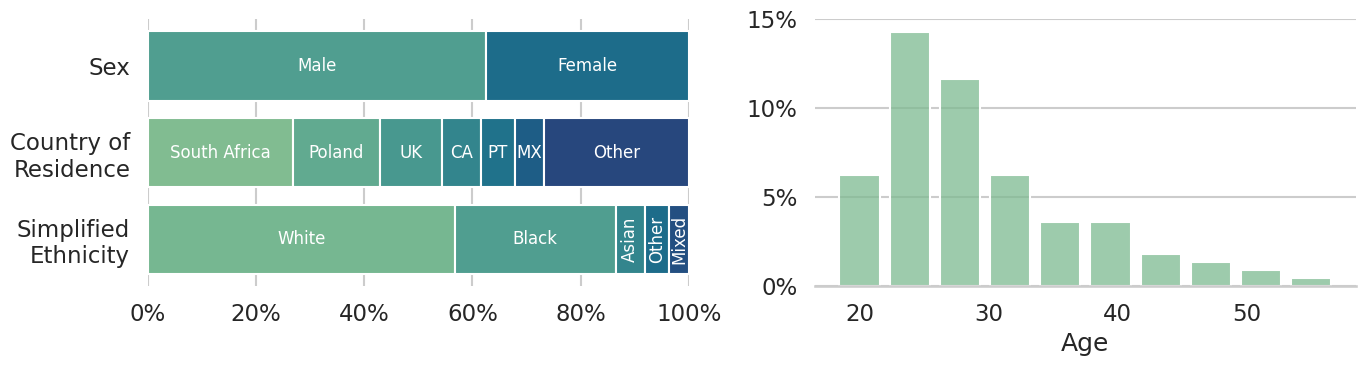

In [68]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(14, 4), squeeze=False)
axes = axes[0, :]

dems_plot = dems.copy().replace(
    {
        "Country of residence": {
            "United Kingdom": "UK",
            "United States": "US",
            "Canada": "CA",
            "Germany": "DE",
            "Portugal": "PT",
            "Mexico": "MX",
            "Spain": "ES",
            "New Zealand": "NZ",
        }
    }
)

eth = dems_plot["Ethnicity simplified"]
eth = eth[eth != "DATA_EXPIRED"]
ethnicity_counts = eth.value_counts(normalize=True) * 100
sex_counts = dems_plot["Sex"].value_counts(normalize=True) * 100
origin_counts = dems_plot["Country of residence"].value_counts(normalize=True) * 100

# Aggregate the smallest ones in origin_counts into "Other"
limit = 5
origin_counts["Other"] = origin_counts[origin_counts < limit].sum()
origin_counts = origin_counts[origin_counts >= limit]

color_palettes = {
    # "Simplified\nEthnicity": sns.color_palette("Set1"),
    # "Sex": sns.color_palette("Set2"),
    # "Country of\nresidence": sns.color_palette("colorblind"),
    "Simplified Ethnicity": sns.color_palette("crest", n_colors=len(ethnicity_counts)),
    "Sex": sns.color_palette("crest", n_colors=len(sex_counts)),
    "Country of Residence": sns.color_palette("crest", n_colors=len(origin_counts)),
}
fontsize = 12

bottom_ethnicity = 0
for index, value in ethnicity_counts.items():
    axes[0].barh(
        "Simplified\nEthnicity",
        value,
        left=bottom_ethnicity,
        label=index,
        color=color_palettes["Simplified Ethnicity"][ethnicity_counts.index.get_loc(index)],
    )
    axes[0].text(
        bottom_ethnicity + value / 2,
        0,
        index,
        ha="center",
        va="center",
        color="white",
        fontsize=fontsize,
        rotation=0 if value > 8 else 90,
    )
    bottom_ethnicity += value

bottom_origin = 0
for index, value in origin_counts.items():
    axes[0].barh(
        "Country of\nResidence",
        value,
        left=bottom_origin,
        label=index,
        color=color_palettes["Country of Residence"][origin_counts.index.get_loc(index)],
    )
    axes[0].text(
        bottom_origin + value / 2,
        1,
        index,
        ha="center",
        va="center",
        color="white",
        fontsize=fontsize,
    )
    bottom_origin += value

bottom_sex = 0
for index, value in sex_counts.items():
    axes[0].barh(
        "Sex",
        value,
        left=bottom_sex,
        label=index,
        color=color_palettes["Sex"][sex_counts.index.get_loc(index)],
    )
    axes[0].text(
        bottom_sex + value / 2,
        2,
        index,
        ha="center",
        va="center",
        color="white",
        fontsize=fontsize,
    )
    bottom_sex += value


axes[0].set_xlim(0, 100)
# axes[0].set_xlabel("Percentage")
axes[0].set_xticklabels([f"{val.get_text()}%" for val in axes[0].get_xticklabels()])
sns.despine(ax=axes[0], left=True, bottom=True)

sns.histplot(x=dems["Age"], shrink=0.8, stat="percent", ax=axes[1])
axes[1].xaxis.grid(False)
axes[1].set_ylabel(None)
axes[1].set_yticklabels([f"{val.get_text()}%" for val in axes[1].get_yticklabels()])
sns.despine(ax=axes[1], left=True)

plt.tight_layout(w_pad=1)

plt.savefig(study_file.absolute().parents[1] / "human_evaluation-demographics.pdf")
plt.show()